In [2]:
# Load Libraries

library(dplyr, quietly = T)
library(GenomicRanges, quietly = T)
library(foreach, quietly = T)
library(doParallel, quietly = T)
library(xgboost, quietly = T)
library(ggplot2, quietly = T)
library(data.table, quietly = T)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind,

Information about data: 
- CAGE-train ("data/CAGE-train"): includes information about gene location and expression. X1 and X2 has train/val info/y, X3 only has test info that we should test on (only testing on chr1). 
- DNase-seq: information on chromatin accessibility (reads only in open chromatin)
- bed, bigwig: genomic regions and associated annotations 
- do not use H3K9me3, distribution too different among X1, X2, X3 

## Work Package 1.1 - Modeling Choices & Data Pre-processing

In [3]:
############################ READ IN DATA ####################################

files <- list.files("./ML4G_Project_1_Data/")
bed_files <- files[stringr::str_detect(files,"-bed")]

# Load the beds, join them and convert them to genomic range objects and 
# store them in a list

cell_lines <- c("X1","X2","X3")

beds <- list()
beds2 <- list()

for (cell_line in cell_lines) {
  temp <- list()
  for (bed_file in bed_files) {
    
    tempII <- data.table::fread(paste0(c("./ML4G_Project_1_Data/",bed_file,"/",cell_line,".bed"),collapse = ""))
    if(bed_file == "DNase-bed" ){ 
      tempII$score <- tempII$V7
      tempII$score_scaled <- scale(tempII$V7) + 2
    } else {
      tempII$score <- tempII$V5
      tempII$score_scaled <- scale(tempII$V5) + 2
    }

    tempII$type <- bed_file
    
    temp[[bed_file]] <- tempII

  }
  
  beds[[cell_line]] <- data.table::rbindlist(temp) 
  beds[[cell_line]]$type <- as.factor(  beds[[cell_line]]$type )
    
  beds2[[cell_line]] <- beds[[cell_line]]
  beds2[[cell_line]]$cell_line <- cell_line
    
  beds[[cell_line]] <-beds[[cell_line]]  %>% GenomicRanges::makeGRangesFromDataFrame(
                                            keep.extra.columns = T,
                                            seqnames.field = "V1",
                                            start.field = "V2",
                                            end.field = "V3")
  

}

Warning message:
“Removed 35222 rows containing non-finite values (stat_density).”Warning message:
“Removed 11150 rows containing non-finite values (stat_density).”

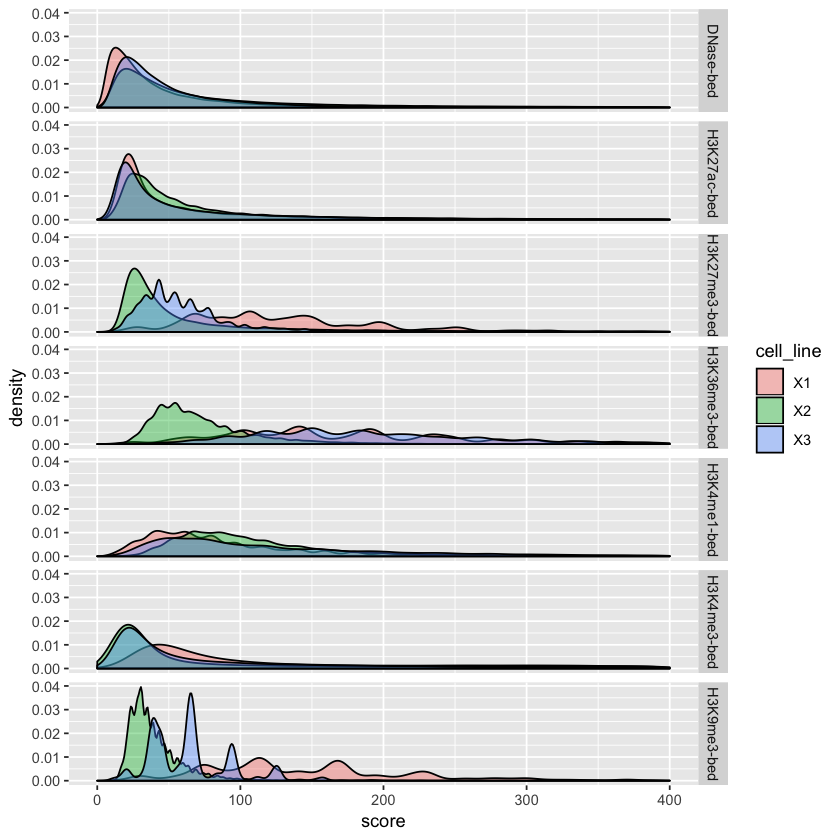

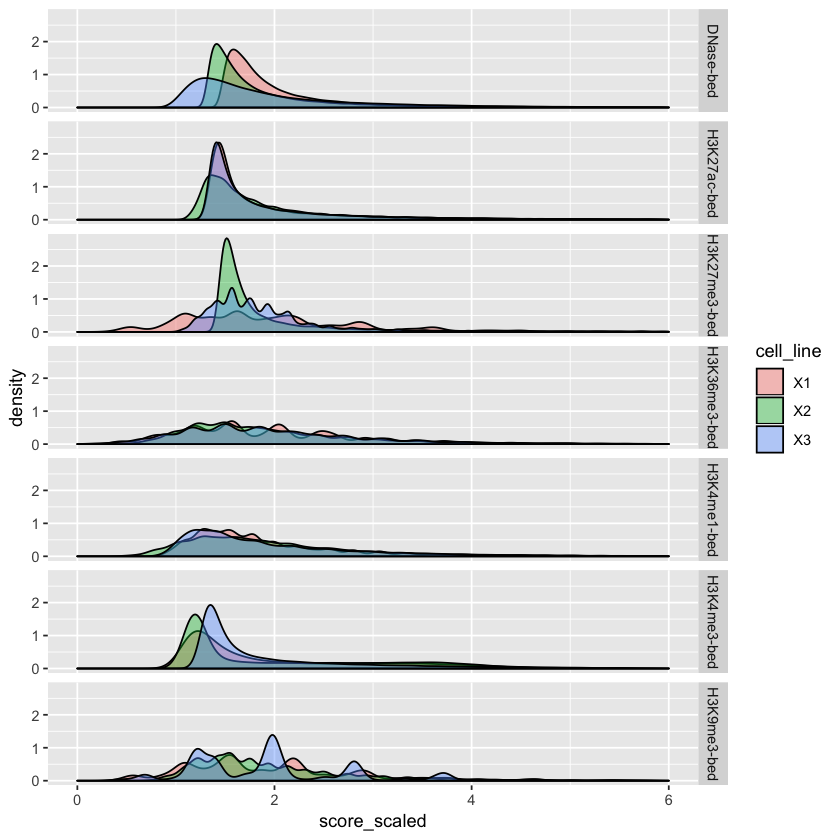

In [4]:
# Plot un-normalized and normalized distribtuion of scores
all_peaks <- data.table::rbindlist(beds2)

ggplot(all_peaks, aes(x=score,fill=cell_line)) + 
  geom_density(alpha=.4) + facet_grid(type ~ .) + xlim(0,400)

ggplot(all_peaks, aes(x=score_scaled,fill=cell_line)) + 
  geom_density(alpha=.4) + facet_grid(type ~ .) + xlim(0,6)

Here we plotted the distribution of scores obtained from different datasets look like, and also observed how the score distribution seemed after normalization. Based on the plot we concluded that normalization did not make a big difference in terms of performance and thus proceeded with non-normalized scores. 

In [5]:
# Load the genes and create GRanges

genesTrain <- data.table::fread("./ML4G_Project_1_Data/CAGE-train/X1_train_info.tsv")
genesVal <- data.table::fread("./ML4G_Project_1_Data/CAGE-train/X1_val_info.tsv")
genesTest <- data.table::fread("./ML4G_Project_1_Data/CAGE-train/X3_test_info.tsv")

genes <- rbind(genesTrain,genesVal) %>% 
  rbind(genesTest) %>%
  GenomicRanges::makeGRangesFromDataFrame(
    keep.extra.columns = T,
    seqnames.field = "chr",
    start.field = "TSS_start",
    end.field = "TSS_end",
    strand.field = "strand")



In [6]:
# define gene set indices store in list for for loop

train_and_val_inds <- which(genes$gene_name %in% c(genesTrain$gene_name,genesVal$gene_name))
test_inds <- which(genes$gene_name %in% genesTest$gene_name)

cell_line_gene_inds <- list(train_and_val_inds,
                         train_and_val_inds,
                         test_inds)

In [7]:
# Define the inner "receptive field"

inner_rF <- 5000
outer_rF <- 200000

# Use the promoters function to expand the gene ranges around the TSS by +- rF

shortIntevals <- promoters(genes,
                          upstream  = inner_rF,
                          downstream= inner_rF)

longIntervals <- promoters(genes,
                          upstream  = outer_rF ,
                          downstream= outer_rF)

# 
geneOverlaps <- findOverlaps(longIntervals,shortIntevals) %>%
                as.data.frame()

# Split single DF into list of DFs
geneOverlaps <- split(geneOverlaps,f = geneOverlaps$queryHits)

In [8]:
########################## CREATE FEATURES ##################################

# Register the parallel backend

num_cores <- 3
registerDoParallel(cores = num_cores)


res <- foreach(j = 1:3, .packages = c("dplyr","GenomicRanges")) %dopar% {
  features  <- list() # Initialize features for cell line j
  
  shortOverlaps <- findOverlaps(shortIntevals,beds[[cell_lines[j]]]) %>%
                   as.data.frame() %>%
                   mutate(queryHits = factor(queryHits,levels = 1:length(genes))) %>%
                   group_by(queryHits,.drop = FALSE) %>%
                   group_split()
  
  LongOverlaps <- findOverlaps(longIntervals,beds[[cell_lines[j]]]) %>%
                  as.data.frame() %>%
                  mutate(queryHits = factor(queryHits,levels = 1:length(genes))) %>%
                  group_by(queryHits,.drop = FALSE) %>%
                  group_split()
            
  
  for (i in cell_line_gene_inds[[j]]) {
    
    feature_bed <- numeric(178) # Number of features
    
    shortInteval <- shortIntevals[i]
          
    longInterval <- longIntervals[i]
    
    geneNeigbourhoodData <- shortIntevals[geneOverlaps[[i]]$subjectHits]
    
    shortRangeData <- beds[[cell_lines[j]]][shortOverlaps[[i]]$subjectHits] 
    
    longRangeData <- beds[[cell_lines[j]]][LongOverlaps[[i]]$subjectHits]
    
    peaks_close_to_a_tssInds <- findOverlaps(geneNeigbourhoodData,longRangeData)
    peaks_not_close_to_a_tssData <- longRangeData[-(peaks_close_to_a_tssInds@to)]
    
    offset <- 0
    for (bed_file in bed_files) {
      
      peaks <- shortRangeData[shortRangeData$type ==  bed_file]
      peaks_distal <- longRangeData[longRangeData$type ==  bed_file]
      peaks_lonely_distal <- peaks_not_close_to_a_tssData[peaks_not_close_to_a_tssData$type ==  bed_file]
      
      feature_bed[1+offset] <- length(peaks) #number_of_peaks
      feature_bed[2+offset] <- length(peaks_distal) - length(peaks) #number_of_distal_peaks
      feature_bed[3+offset] <- length(peaks_lonely_distal) # number_of_distal_lonely_peaks

      
      if (feature_bed[1+offset] > 0) {


        peak_centers <- (start(peaks) + end(peaks)) / 2
        
        center_dis <- peak_centers - ((start(shortInteval) + end(shortInteval))) / 2
        feature_bed[4+offset] <- center_dis[which.min(abs(center_dis))] #distance_to_closest_peak_signed
        feature_bed[5+offset] <- center_dis[which.max(abs(center_dis))] #distance_to_furthest_peak_signed
        feature_bed[6+offset] <- min(abs(center_dis))                 # distance_to_closest_peak_unsigned
        feature_bed[7+offset] <- sum(peaks$score) #sum_of_scores
        feature_bed[8+offset] <- peaks[which.min(abs(center_dis)), ]$score #score_of_closet_peak
        feature_bed[9+offset] <- peaks[which.max(abs(center_dis)), ]$score #score_of_furthest_peak
        feature_bed[10+offset] <- max(peaks$score) #max_peak
        feature_bed[11+offset] <- mean(peaks$score) #mean_peak
        
        # Binned Peak score sum vectors
        
        intervals <- seq(start(shortInteval),end(shortInteval) + 50,by=1000)
        intervals[1]  <- intervals[1]  - 100000
        intervals[11] <- intervals[11] + 100000
        bincodes <- .bincode(peak_centers,intervals)
        for (r in 1:length(peaks)) {
          feature_bed[11+offset+bincodes[r]] <- feature_bed[11+offset+bincodes[r]] + peaks[r]$score
        }
        
        
      } else{
        
        feature_bed[4+offset] <- 1000000 #distance_to_closest_peak_signed
        feature_bed[5+offset] <- 1000000 #distance_to_furthest_peak_signed
        feature_bed[6+offset] <- 1000000 #distance_to_closest_peak_unsigned
        feature_bed[7+offset] <- 0 #sum_of_scores
        feature_bed[8+offset] <- 0 #score_of_closet_peak
        feature_bed[9+offset] <- 0 #score_of_furthest_peak
        feature_bed[10+offset] <- 0 #max_peak
        feature_bed[11+offset] <- 0#mean_peak
        
      }
      if (feature_bed[2+offset] > 0) {
        feature_bed[22+offset] <- sum(peaks_distal$score) - feature_bed[7+offset] # sum_of_scores_distal
        feature_bed[23+offset] <- feature_bed[22+offset]/feature_bed[2+offset] # mean_of_score_distal
        # Add distance to closest distal peak ??? 
      } else {
        feature_bed[22+offset] <- 0 # sum_of_scores_distal
        feature_bed[23+offset] <- 0 # mean_of_score_distal
      }
      if(feature_bed[3+offset]> 0){
        feature_bed[24+offset] <- max(peaks_lonely_distal$score) # lonely_distal_max
        feature_bed[25+offset] <- mean(peaks_lonely_distal$score) # lonely_distal_mean
      } else {
        feature_bed[24+offset] <- 0 # lonely_distal_max
        feature_bed[25+offset] <- 0 # lonely_distal_mean
      }
      offset <- offset + 25
    }


    feature_bed[176] <- (genes[i]$gene_end - genes[i]$gene_start) # gene_length
    feature_bed[177] <- length(geneNeigbourhoodData) - 1 # number_of_genes_in_large_neighbourhood
    feature_bed[178] <-  as.numeric(strand(genes[i]) == "+") # Strand
    
    
    features[[genes[i]$gene_name]] <- feature_bed
    
  }
  features
}
stopImplicitCluster()


In [19]:
# Create data.frames of the results 
# Load response vars

train_vals_x1 <- data.table::fread("./ML4G_Project_1_Data/CAGE-train/X1_train_y.tsv")
train_vals_x2 <- data.table::fread("./ML4G_Project_1_Data/CAGE-train/X2_train_y.tsv")

validation_vals_x1 <- data.table::fread("./ML4G_Project_1_Data/CAGE-train/X1_val_y.tsv")
validation_vals_x2 <- data.table::fread("./ML4G_Project_1_Data/CAGE-train/X2_val_y.tsv")

features <- c("number_of_peaks",
              "number_of_distal_peaks",
              "number_of_distal_lonely_peaks",
              "distance_to_closest_peak_signed",
              "distance_to_furthest_peak_signed",
              "distance_to_closest_peak_unsigned",
              "sum_of_scores",
              "score_of_closet_peak",
              "score_of_furthest_peak",
              "max_peak",
              "mean_peak",
              paste0("bin_",1:10),
              "sum_of_scores_distal",
              "mean_of_score_distal",
              "lonely_distal_max",
              "lonely_distal_mean"
)


feature_cols <- c()
for (bed_file in bed_files) {
  feature_cols <- c(feature_cols,paste0(features,"_",strsplit(bed_file,"-bed")[[1]]))
}
feature_cols <- c(feature_cols,"gene_length","number_of_genes_in_large_neighbourhood","strand")

# GET DATA INTO RIGHT ORDER

examine <- data.frame(res[[1]]) 
rownames(examine) <- feature_cols


x1_feat <- data.frame(t(data.frame(res[[1]])))
colnames(x1_feat) <- feature_cols

rownames(x1_feat) <-  c(train_vals_x1$gene_name,validation_vals_x1$gene_name)
x1_feat$y_val <- c(train_vals_x1$gex,validation_vals_x1$gex)


x2_feat <- data.frame(t(data.frame(res[[2]])))
colnames(x2_feat) <- feature_cols

rownames(x2_feat) <-  c(train_vals_x2$gene_name,validation_vals_x2$gene_name)
x2_feat$y_val <- c(train_vals_x2$gex,validation_vals_x2$gex)

x3_feat <- data.frame(t(data.frame(res[[3]])))
colnames(x3_feat) <- feature_cols
rownames(x3_feat) <-  c(genesTest$gene_name)


train_complete <-data.frame(rbind(x1_feat[train_vals_x1$gene_name,],
                                  x2_feat[train_vals_x2$gene_name,]))

val_complete <-data.frame(rbind(x1_feat[rownames(x1_feat) %in% validation_vals_x1$gene_name  ,],
                                x2_feat[rownames(x2_feat) %in% validation_vals_x2$gene_name,]))

test_complete <- x3_feat

In [36]:
#make this example reproducible
set.seed(0)

# Test using only certain features
train_complete<- train_complete %>%
  select(-contains("H3K9me3"))

val_complete<- val_complete %>%
  select(-contains("H3K9me3"))

train_complete<- train_complete %>%
  select(-contains("H3K9me3"))


#define final training and testing sets
 

xgb_train = xgb.DMatrix(data =  data.matrix(train_complete[,-ncol(train_complete)]),
                        label = train_complete[,ncol(train_complete)])

xgb_test = xgb.DMatrix(data = data.matrix(val_complete[,-ncol(val_complete)]),
                       label = val_complete[,ncol(val_complete)])

test_complete <- test_complete %>%
  select(-contains("H3K9me3"))

xgb_real_test = xgb.DMatrix(data = data.matrix(test_complete))


## Work Package 1.2 - Model Building

In [21]:
# Create XGboost watchlist to monitor the training

watchlist = list(train=xgb_train, test=xgb_test)

# Create a evalation function to use to montior the training

evalerror <- function(preds, dtrain) {
  labels <- getinfo(dtrain, "label")
  err <- cor(labels , preds,method = "spearman")
  return(list(metric = "spearman", value = err))
}


# Define a set of parameters to use (thse)

param <- list(objective = "count:poisson",
                          eval_metric = evalerror,
                           subsample = 0.7,
                           colsample_bytree= 0.4,
                           lambda = 100,
                           alpha = 750)


In [22]:
# Train a XGboost model with the above parameters (monitor loss to find optimal nrounds)
model = xgb.train(data = xgb_train,
                  max.depth = 6,
                  watchlist=watchlist,
                  nrounds = 500,
                  params = param)

[1]	train-spearman:0.595655	test-spearman:0.601685 
[2]	train-spearman:0.617816	test-spearman:0.614821 
[3]	train-spearman:0.624795	test-spearman:0.620208 
[4]	train-spearman:0.642048	test-spearman:0.632865 
[5]	train-spearman:0.647151	test-spearman:0.639545 
[6]	train-spearman:0.646778	test-spearman:0.637950 
[7]	train-spearman:0.666359	test-spearman:0.656222 
[8]	train-spearman:0.669008	test-spearman:0.659298 
[9]	train-spearman:0.684500	test-spearman:0.681843 
[10]	train-spearman:0.685291	test-spearman:0.683545 
[11]	train-spearman:0.689069	test-spearman:0.685991 
[12]	train-spearman:0.690293	test-spearman:0.686012 
[13]	train-spearman:0.722871	test-spearman:0.727320 
[14]	train-spearman:0.727590	test-spearman:0.734891 
[15]	train-spearman:0.732798	test-spearman:0.739615 
[16]	train-spearman:0.733717	test-spearman:0.741033 
[17]	train-spearman:0.740397	test-spearman:0.744862 
[18]	train-spearman:0.741154	test-spearman:0.746925 
[19]	train-spearman:0.743053	test-spearman:0.749047 
[2

In [53]:
############################ HYPERPARAM SEARCH ####################################

# Dumb grid search (DONT RUN)

validation_pearsons <- list()
iter <- 0

for (max_depth in 4:7) {
  for (alpha in c(0,500,750, 1000)) {
    for (colsample in c(0.3,0.4,0.5)) {
      for (lambda in c(1, 500, 1000)) {
  
      
      param <- list(objective = "count:poisson",
                    eval_metric = evalerror,
                    subsample = 0.8,
                    colsample_bytree= colsample,
                    lambda = lambda,
                    alpha = alpha)
      
        model = xgb.train(data = xgb_train,
                          max.depth = max_depth,
                          watchlist=watchlist,
                          nrounds = 500,
                          params = param,
                          verbose = 0)
        validation_pearsons[[paste(max_depth,
                             alpha,
                             colsample,
                             lambda)]] <- model$evaluation_log$test_spearman
        iter <- iter + 1
        print(paste("iter", iter, max_depth, alpha, colsample, lambda, max(model$evaluation_log$test_spearman)))
      }
    }
  }
}


# best 6 750 0.4 1000 with 0.7817005
# after adding more features and redoing hyperparam search (Apr 3)
# best: 6 750 0.3 1000 with 0.7844057



[1] "iter 1 4 0 0.3 1 0.772206509967975"
[1] "iter 2 4 0 0.3 500 0.774526761856252"
[1] "iter 3 4 0 0.3 1000 0.77834369523984"
[1] "iter 4 4 0 0.4 1 0.769320304566917"
[1] "iter 5 4 0 0.4 500 0.77129605206307"
[1] "iter 6 4 0 0.4 1000 0.774599640854155"
[1] "iter 7 4 0 0.5 1 0.773254750802353"
[1] "iter 8 4 0 0.5 500 0.778151501992582"
[1] "iter 9 4 0 0.5 1000 0.774792741789106"
[1] "iter 10 4 500 0.3 1 0.776545308981807"
[1] "iter 11 4 500 0.3 500 0.781525649540254"
[1] "iter 12 4 500 0.3 1000 0.777446042492145"
[1] "iter 13 4 500 0.4 1 0.773802637140573"
[1] "iter 14 4 500 0.4 500 0.777261233894549"
[1] "iter 15 4 500 0.4 1000 0.776712103146623"
[1] "iter 16 4 500 0.5 1 0.776908862477814"
[1] "iter 17 4 500 0.5 500 0.776270914021349"
[1] "iter 18 4 500 0.5 1000 0.775164382262725"
[1] "iter 19 4 750 0.3 1 0.778446277330344"
[1] "iter 20 4 750 0.3 500 0.77549910268472"
[1] "iter 21 4 750 0.3 1000 0.776599933773798"
[1] "iter 22 4 750 0.4 1 0.779913312881657"
[1] "iter 23 4 750 0.4 500 

ERROR: Error in data.frame(iteration = 1:length(test_pearsons[[1]]), stack(sapply(test_pearsons, : 객체 'test_pearsons'를 찾을 수 없습니다


Warning message:
“Removed 2644 rows containing missing values (geom_path).”

      iteration iter hyperparameter      loss
46388       388  388 6 750 0.3 1000 0.7844057


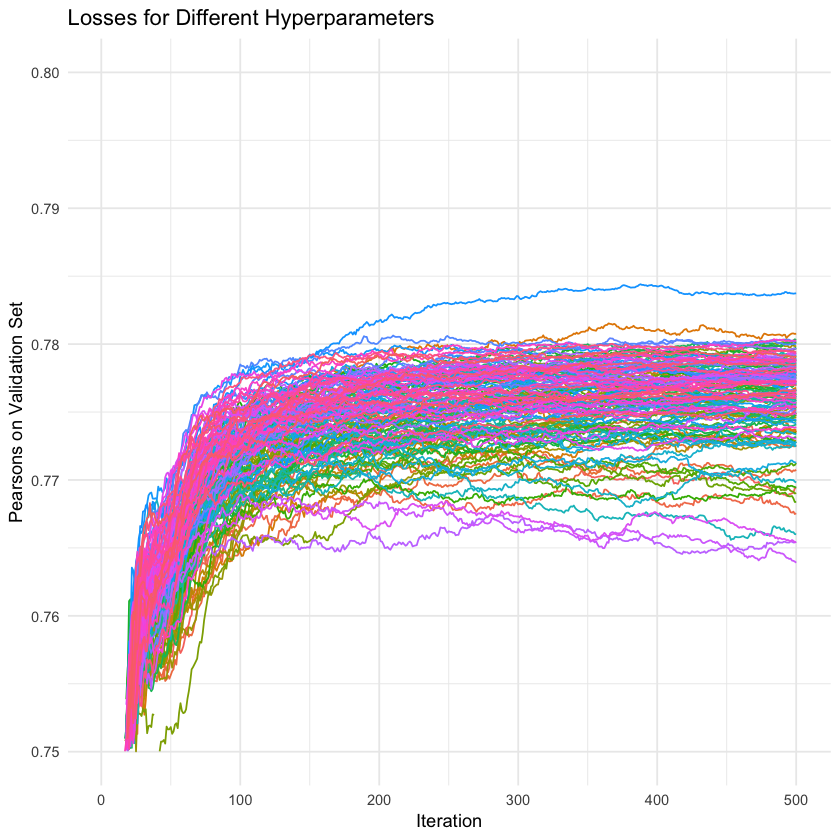

In [58]:
losses_df <- data.frame(
  iteration = 1:length(validation_pearsons[[1]]),
  stack(sapply(validation_pearsons, `length<-`, max(lengths(validation_pearsons))))
)

# Rename the columns
colnames(losses_df) <- c("iteration", "iter", "hyperparameter","loss")

# Plot the losses using ggplot2
ggplot(data = losses_df, aes(x = iteration, y = loss, color = as.factor(hyperparameter))) +
  geom_line() +
  labs(title = "Losses for Different Hyperparameters",
       x = "Iteration",
       y = "Pearsons on Validation Set",
       color = "Max Depth") +
       ylim(0.75,0.8) +
       theme_minimal() +
       theme(legend.position="none") 
        
  

  print(losses_df[which.max(losses_df$loss),])


Based off of the parameters that we found from the grid search, we trained the model on both the training and validation data. 

In [1]:
# Train optimal model with train and validation data
train_and_val <- rbind(train_complete,val_complete)

xgb_train_and_val <- xgb.DMatrix(data =  data.matrix(train_and_val[,-ncol(train_and_val)]),
                        label = train_and_val[,ncol(train_and_val)])

# take the param from the best model
param <- list(objective = "count:poisson", 
              eval_metric = evalerror,
              subsample = 0.8,
              colsample_bytree= 0.3,
              lambda = 1000,
              alpha = 750)


final <- xgboost(data = xgb_train_and_val,
                max.depth = 6,
                nrounds = 480,
                params = param)

ERROR: Error in rbind(train_complete, val_complete): 객체 'train_complete'를 찾을 수 없습니다


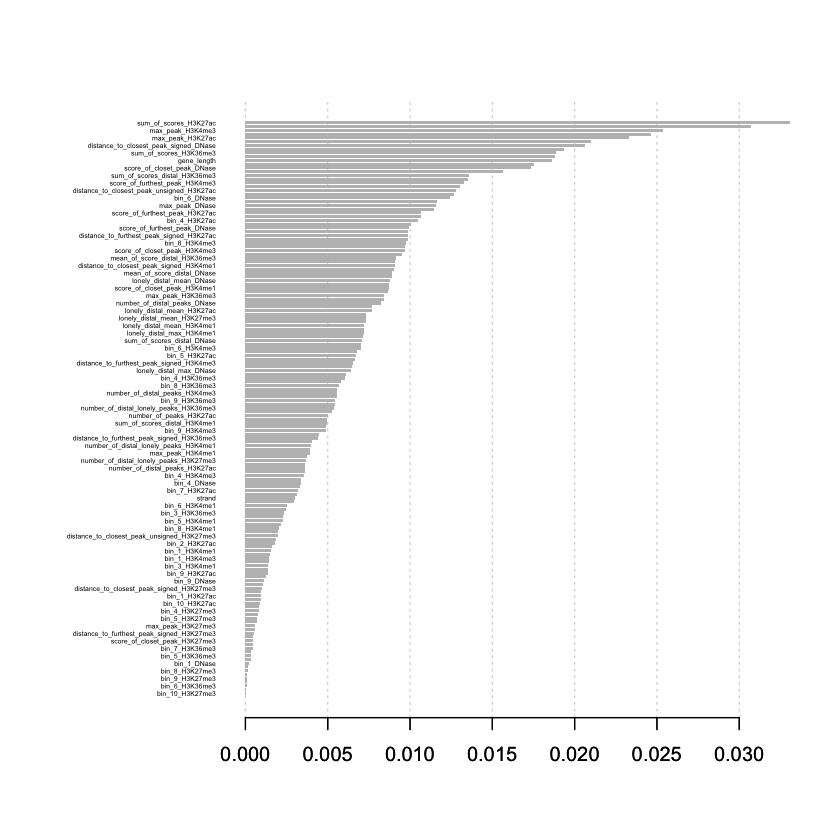

In [33]:
# Look at feature importances 

feature_importance <- xgboost::xgb.importance(model = final)
xgboost::xgb.plot.importance(feature_importance)
#xgb.plot.shap(data.matrix(xgb_train_and_val[,-ncol(xgb_train_and_val)]), model = final,top_n = 10)
#xgb.plot.shap.summary(data.matrix(xgb_train_and_val[,-ncol(xgb_train_and_val)]), model = final)

## Work Package 1.3 - Prediction on Test Data (Evaluation Metric)

Please note that we did not follow the code chunks provided in the original skeleton but ensured that the submission csv followed the required format. 

In [44]:
# Using the model trained in WP 1.2, make predictions on the test data (chr 1 of cell line X3).
# Store predictions in a variable called "pred" which is a numpy array.
# ---------------------------INSERT CODE HERE---------------------------

# Write down the predicted values
pred_y = predict(final, xgb_real_test)

pred <- data.frame("gene_name" = genesTest$gene_name,
                    "gex_predicted" = pred_y,
                    row.names = 0:(length(pred_y)-1))

# write.csv(pred, file = "gex_predicted.csv",row.names = T,quote = FALSE)


# ----------------------------------------------------------------------

# Check if "pred" meets the specified constraints
print(is.numeric(pred$gex_predicted))
print(nrow(pred) == length(genesTest$gene_name))

[1] TRUE
[1] TRUE


#### Store Predictions in the Required Format

In [48]:
# Store predictions in a ZIP.
# Upload this zip on the project website under "Your submission".
# Zip this notebook along with the conda environment (and README, optional) and upload this under "Your code".

save_dir <- getwd()  # TODO
file_name <- 'gex_predicted.csv'         # PLEASE DO NOT CHANGE THIS
zip_name <- "Jung_HuiJeong_Project1.zip" # TODO
save_path <- paste(save_dir, zip_name, sep="/")

write.csv(pred, file = "gex_predicted.csv",row.names = T,quote = FALSE)

# Create the zip file
utils::zip(zip_name, files = c(file_name))

# Move the zip file to the save directory
file.rename(zip_name, save_path)

# Remove the csv file
file.remove(file_name)

[1] TRUE

[1] TRUE